# Advanced Lane Finding

## Udacity Self Driving Car Engineer Nanodegree - Project 4¶ 

The goal of this project is to write a software pipeline to identify the lane boundaries in a video captured by a camera installed at the center of a car windowshield. Items to be identified are as follow:
The positions of the road lines
The location of the car relative to the lane
The radius of curvature of the lines/road

In [1]:
# importing the required libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from collections import deque
from IPython.display import HTML
%matplotlib inline


## Camera Calibration and Undistortion

Finding chessboard corners

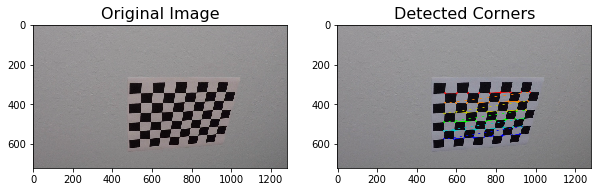

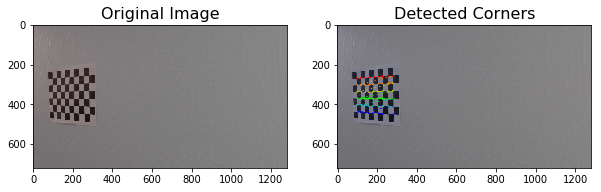

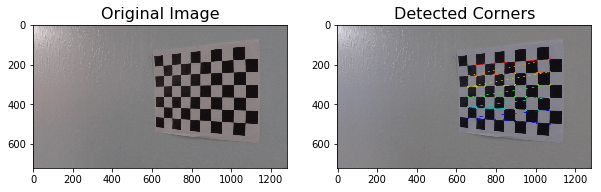

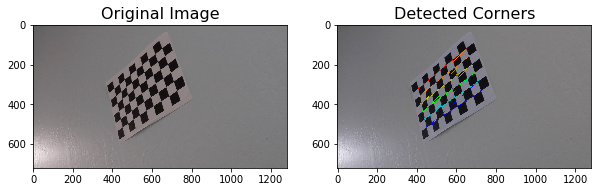

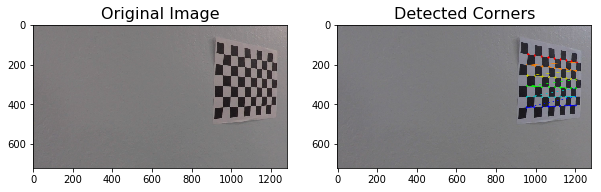

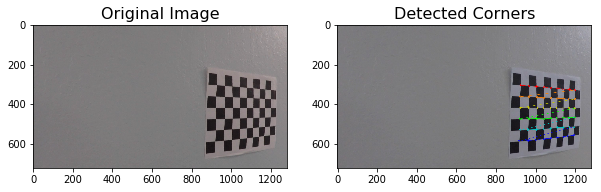

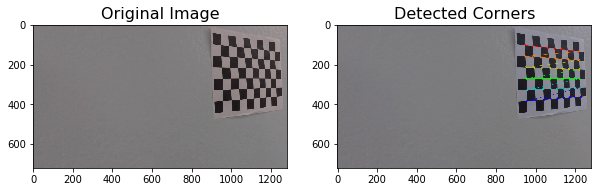

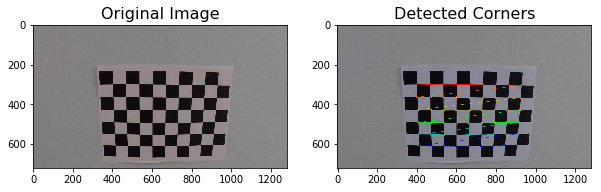

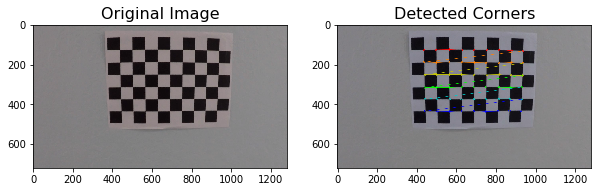

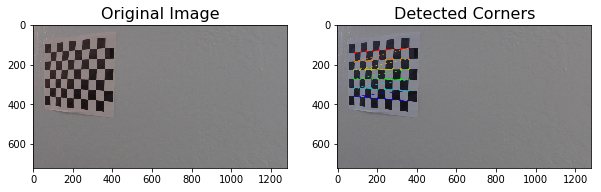

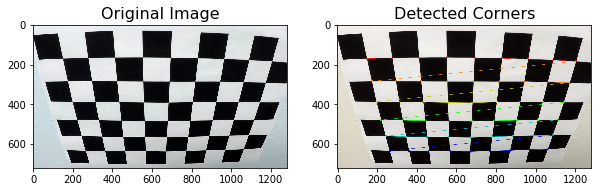

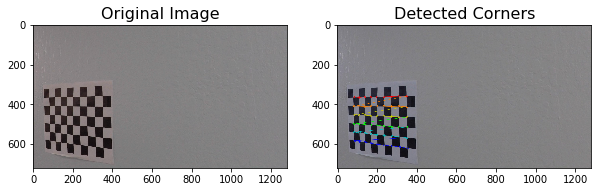

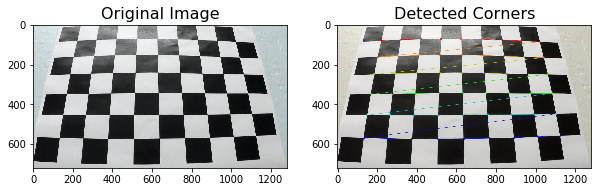

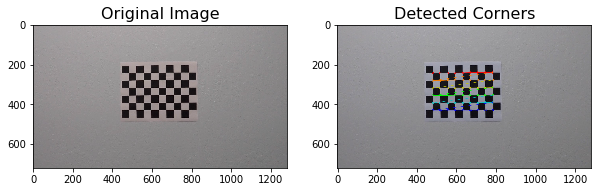

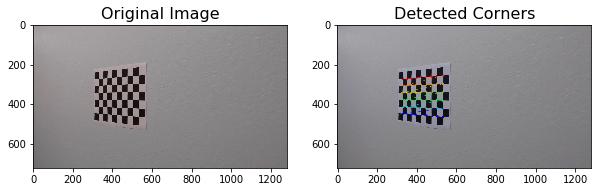

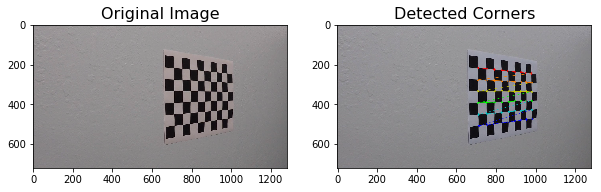

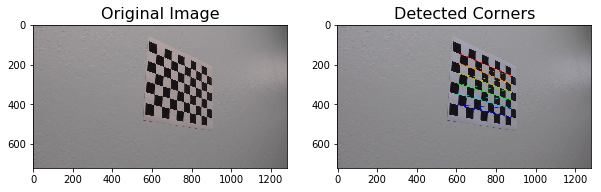

In [2]:
#Creating an array of object points like (0,0,0) (1,0,0) .... (9,6,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Directory to look for calibration images
images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,6))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Detected Corners', fontsize=16)

In [3]:
#Defining undistort method
def undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

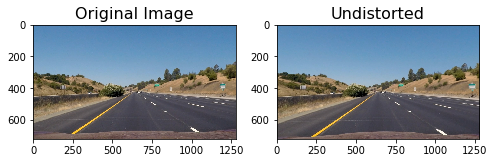

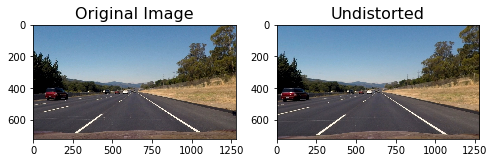

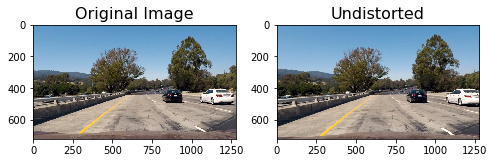

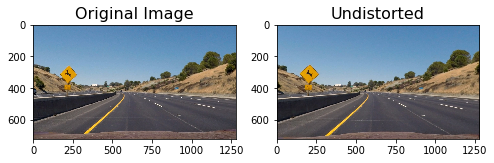

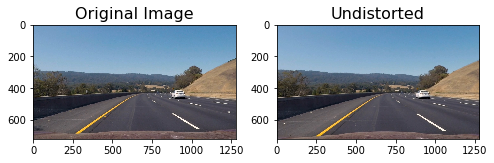

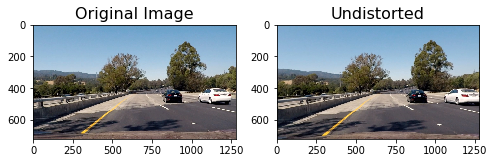

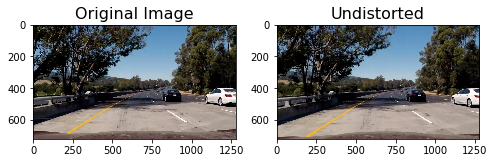

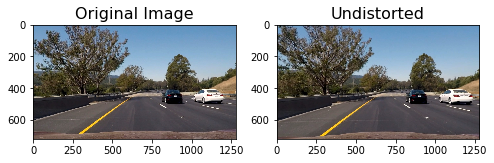

In [26]:
images=glob.glob('test_images/*.jpg') 
for image in images:
    img = cv2.imread(image)
    undist=undistort(img, objpoints, imgpoints)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=16)
    ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted', fontsize=16)

## Perspective Transformation

In [5]:
#Defining Warp method

def warp(img):
    src=np.float32([[550,480], [730, 480], [195, 720], [1085, 720]])
    dst=np.float32([[300,0], [980,0], [300,720], [980,720]])
    img_size=(img.shape[1], img.shape[0])
    M=cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped=cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

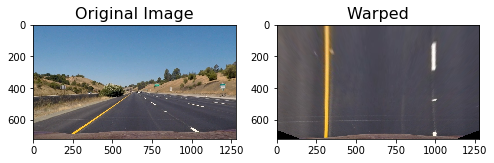

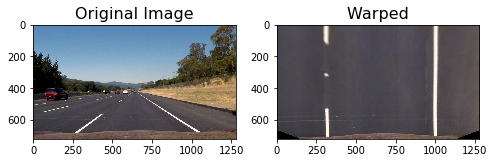

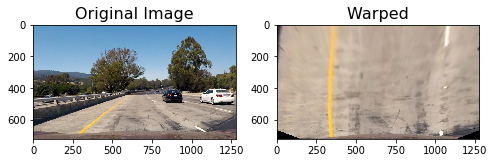

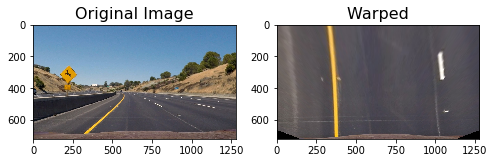

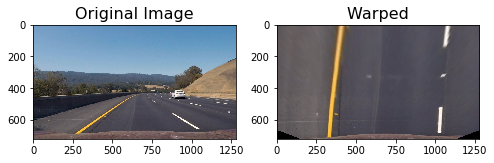

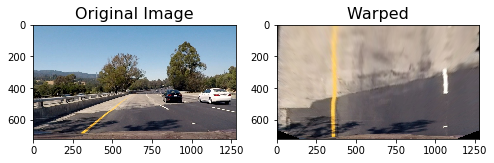

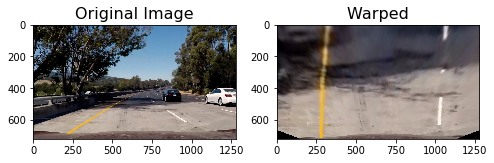

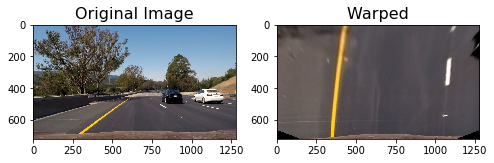

In [30]:
for image in images:
    img = cv2.imread(image)
    undist=undistort(img, objpoints, imgpoints)
    warped, M, Minv = warp(undist)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=16)
    ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    ax2.set_title('Warped', fontsize=16)

## Creating Binary Threshold Images

In [7]:
# Create binary thresholding method
def binary(img):
    # img must be an undistorted image

    #creating an image with hsl channels and filtering for S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sobx_thresh_min = 40 #20
    sobx_thresh_max = 150 #90
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sobx_thresh_min) & (scaled_sobel <= sobx_thresh_max)] = 1
    

    # Threshold color channel
    s_thresh_min = 180 #180
    s_thresh_max = 255 #255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Threshold Lightness channel
    l_thresh_min = 200
    l_thresh_max =255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    # Threshold b channel
    b_thresh_min = 144
    b_thresh_max =160
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sxbinary == 1) | (s_binary == 1) | (l_binary == 1) | (b_binary == 1)] = 1
    
    
    
    return  combined_binary #sxbinary, s_binary, l_binary, b_binary #combined_binary

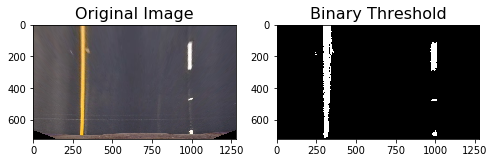

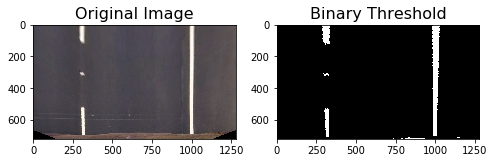

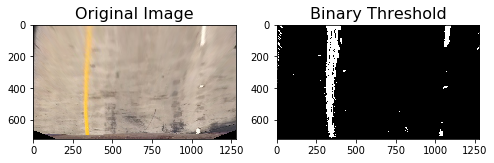

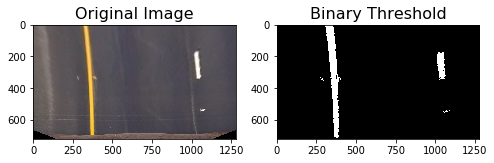

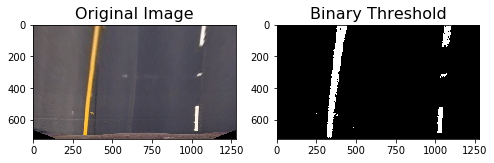

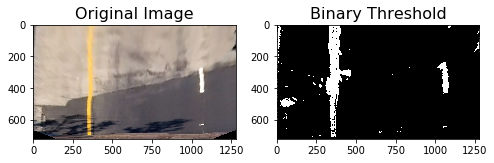

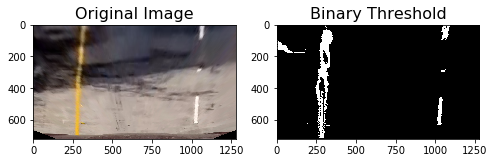

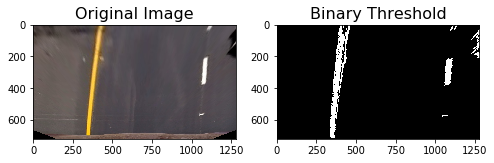

In [28]:
# Plotting thresholded images
for image in images:
    img=cv2.imread(image)
    undist=undistort(img, objpoints, imgpoints)
    combined= binary(undist)
    combined, M, Minv = warp(combined)
    f, (ax1, ax2)= plt.subplots(1, 2, figsize=(8,4))
    ax1.imshow(cv2.cvtColor(warp(img)[0], cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=16)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Binary Threshold', fontsize=16)
    
#     sx, s, l, b= binary(undist)
#     sx, M=warp(sx)
#     s, M=warp(s)
#     l, M=warp(l)
#     b, M=warp(b)
#     f, ((ax1, ax2), (ax3, ax4), (ax5, ax6))= plt.subplots(3, 2, figsize=(18,9))
#     ax1.imshow(cv2.cvtColor(warp(img)[0], cv2.COLOR_BGR2RGB))
#     ax1.set_title('Original Image', fontsize=16)
#     ax2.imshow(sx, cmap='gray')
#     ax2.set_title('sx', fontsize=16)
#     ax3.imshow(s, cmap='gray')
#     ax3.set_title('s', fontsize=16)
#     ax4.imshow(l, cmap='gray')
#     ax4.set_title('l', fontsize=16)
#     ax5.imshow(b, cmap='gray')
#     ax5.set_title('b', fontsize=16)
#     ax6.imshow(b, cmap='gray')
#     ax6.set_title('b', fontsize=16)

## Fitting Polynomial on Detected Line Pixels

In [9]:
def fit_line(binary_warped, margin=100, minpix=50, plot=True):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[360:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #visualization
    if plot==True:
        
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

## Visualization of Sliding Window

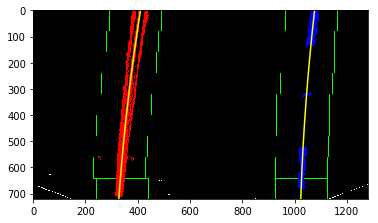

In [31]:
# Generate x and y values for plotting
img=cv2.imread('test_images/test3.jpg')
undist=undistort(img, objpoints, imgpoints)

combined, M, Minv = warp(undist)
binary_warped= binary(combined)
left_fit, right_fit, left_lane_inds, right_lane_inds = fit_line(binary_warped, margin=100, minpix=50)


## Fitting Line Based on Previous Fit

In [32]:
def margin_search(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds

6.09343504137e-05


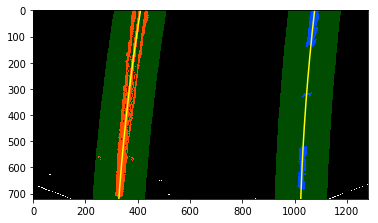

In [33]:

left_fit, right_fit, left_lane_inds, right_lane_inds = margin_search(binary_warped, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

margin=100

# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

print (left_fit[0])

## Calculating Line Curvature Radius

In [34]:
def curv_rad(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/680 # meters per pixel in x direction 
    
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    
    #set y yalue where the curvature needs to be measured. Here I selected the midpoint in the warped image
    h = binary_warped.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)/2
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of left_fit and right_fit intercepts 
    if right_fit is not None and left_fit is not None:
        car_position = binary_warped.shape[1]/2
        left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (right_fit_x_int + left_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix

    return left_curverad, right_curverad, center_dist

In [35]:
left_curverad, right_curverad, center_dist = curv_rad(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds)
print (left_curverad,'m','   ', right_curverad,'m')

2619.02001547 m     2863.66794791 m


## Projecting Detected Lane on Original Image

In [15]:
def project_lane(orig_img, binary_warped, left_fit, right_fit, Minv, plot=True):
    
    h,w = binary_warped.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (orig_img.shape[1], orig_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)
    if plot==True:
        plt.imshow(result)
    
    return result


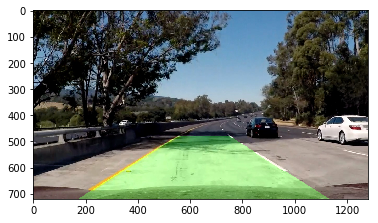

In [16]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
visualized = project_lane(img, binary_warped, left_fit, right_fit, Minv)

## Projecting Radius of Curvature and Distance from Center of Lane on Image

In [17]:
def draw_data(orig_img, left_curverad, right_curverad, center_dist):
    curv_rad = (left_curverad + right_curverad)/2
    new_img = np.copy(orig_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_TRIPLEX 
    text = 'Curvature Rad: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (50,70), font, 1.25, (255,255,255), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of car'
    cv2.putText(new_img, text, (50,120), font, 1.25, (255,255,255), 2, cv2.LINE_AA)

    return new_img


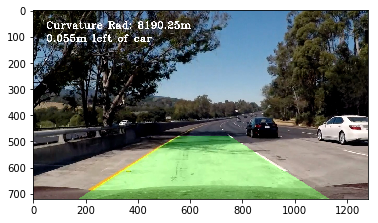

In [18]:
visualized1 = draw_data(visualized, left_curverad, right_curverad, center_dist)
plt.imshow(visualized1)

## Defining Line Class to Store Useful Data

In [19]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #fit coefficient values over the last n iterations
        self.recent_left_fits = [np.array([False, False, False])]
        self.recent_right_fits = [np.array([False, False, False])]
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        self.left_fit = [np.array([0, 0, 0])]  
        self.right_fit = [np.array([0, 0, 0])]
        
        self.left_lowx= None
        self.right_lowx=None
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## Image Processing Pipeline

In [20]:
def img_preprocess(img):
    
    #undist
    img_proc = undistort(img, objpoints, imgpoints)
    #warp
    img_proc, M, Minv = warp(img_proc)
    #binary
    img_proc= binary(img_proc)
    
    return img_proc, Minv

## Video Processing Pipeline

In [21]:
def line_process(img):
    
    img_proc, Minv = img_preprocess(img)
    
    ploty = np.linspace(0, img_proc.shape[0]-1, img_proc.shape[0] )
    
    y_max = np.max(ploty)
    
    left_fit=line.left_fit
    
    right_fit=line.right_fit
    
    
    if line.detected == False:
        
        left_fit, right_fit, left_lane_inds, right_lane_inds = fit_line(img_proc, margin=100, minpix=50, plot=False)

        line.detected=True
        
        line.left_lowx = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
        
        line.right_lowx = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
        
        lane_width_diff=abs((right_fit[2]-left_fit[2])-(line.right_lowx-line.left_lowx))
        
        #Checking whether the lines are relatively parallel
        
        if 50 < lane_width_diff:
            
            line.detected=False
            
            left_fit=line.left_fit
            
            right_fit=line.right_fit
        
        #Storing previous fits
        
        if len(line.recent_left_fits)<4:
                
            line.recent_left_fits=np.append(line.recent_left_fits,[left_fit],axis=0)

            line.recent_right_fits=np.append(line.recent_right_fits,[right_fit],axis=0)

        else:

            line.recent_left_fits=np.delete(line.recent_left_fits,0,axis=0)

            line.recent_left_fits=np.append(line.recent_left_fits,[left_fit],axis=0)

            line.recent_right_fits=np.delete(line.recent_right_fits,0,axis=0)

            line.recent_right_fits=np.append(line.recent_right_fits,[right_fit],axis=0)
        
    else:
        
        left_fit, right_fit, left_lane_inds, right_lane_inds = margin_search(img_proc, left_fit, right_fit)
        
        line.left_lowx = left_fit[0]*y_max**2 + left_fit[1]*y_max + left_fit[2]
        
        line.right_lowx = right_fit[0]*y_max**2 + right_fit[1]*y_max + right_fit[2]
        
        lane_width_diff=abs((right_fit[2]-left_fit[2])-(line.right_lowx-line.left_lowx))
        
        #Checking whether the lines are relatively parallel
        
        if 50 < lane_width_diff:
            
            line.detected=False
            
            left_fit=line.left_fit
            
            right_fit=line.right_fit
            
        #Storing previous fits
        
        if len(line.recent_left_fits)<4:

            line.recent_left_fits=np.append(line.recent_left_fits,[left_fit],axis=0)

            line.recent_right_fits=np.append(line.recent_right_fits,[right_fit],axis=0)

        else:

            line.recent_left_fits=np.delete(line.recent_left_fits,0,axis=0)

            line.recent_left_fits=np.append(line.recent_left_fits,[left_fit],axis=0)

            line.recent_right_fits=np.delete(line.recent_right_fits,0,axis=0)

            line.recent_right_fits=np.append(line.recent_right_fits,[right_fit],axis=0)
    
    if len(line.recent_left_fits)==4:
        
        left_fit=np.average(line.recent_left_fits,0,[1,2,3,5])
        
        right_fit=np.average(line.recent_right_fits,0,[1,2,3,5])
    else:
        
        left_fit=np.average(line.recent_left_fits,0)
        
        right_fit=np.average(line.recent_right_fits,0)
        
        
    line.left_fit=left_fit
    
    line.right_fit=right_fit
    
    left_curverad, right_curverad, center_dist = curv_rad(img_proc, left_fit, right_fit, left_lane_inds, right_lane_inds)
    
    img_proc = project_lane(img, img_proc, left_fit, right_fit, Minv, plot=False)
    
    img_proc = draw_data(img_proc, left_curverad, right_curverad, center_dist)

    return img_proc

In [22]:
line=Line()

project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(line_process) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

# # ffmpeg_extract_subclip("project_video.mp4", 0, 4, targetname="test2.mp4")

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|███████████████████████████████████████████████████████████████▉| 1260/1261 [18:27<00:00,  1.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 18min 29s
